# Compare Spatiotemporal Power Spectra for different Conditions

How do different conditions compare!?!?

## Dependencies

In [19]:
import os, stat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import imp

#import utils.run_analysis as ana

import stftoolkit as stf
import datatable as dt

import imageio
import cv2
import pandas as pd

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
import matplotlib.colors as colors

## Parameters

*** NOTE: REALLY NEED TO CHECK ON THE VALUES FOR HORIZONTAL AND VERTICAL FOV ***

In [20]:
base_dir = '/hmet_data/ago_pilot_feb2020'
data_dir = os.path.join(base_dir, 'analysis')
output_dir = os.path.join(base_dir, './ps_output')

fps = 200

###DEFINITELY NEED TO CHECK ON THESE VALUES
horizontal_fov_deg = 61
#vertical_fov_deg = 61

img_dims=(1544,2064)
save_batchsize = 200

chunk_secs = 2
chunk_pix = 512
chunk_frames = int(chunk_secs*fps)

num_chunks = 100

trace_type='none'

cosine_window = True

#where are there atifacts? cut them off before plotting
spatial_cuttoff_cpd = 12 #14
temporal_cuttoff_fps = np.inf

#vertical_ppd = img_dims[0]/vertical_fov_deg
horizontal_ppd = img_dims[1]/horizontal_fov_deg
#ppd = np.mean((vertical_ppd, horizontal_ppd))
ppd = horizontal_ppd
print(ppd)
#print(f'Vertical PPD: {vertical_ppd:.2f}, Horizontal PPD {horizontal_ppd:.2f}, taking average {ppd:.2f}')

33.83606557377049


## Specify Directories for Exmaple

In [21]:
#trials = pd.read_csv('./trial_list.csv')
trials = pd.read_csv(os.path.join(base_dir,'trial_list.csv'))
tasks = trials['task']
iters = trials['iter']
subjects = trials['subject']

task_weightings = {'book': 1,
                   'chat': 1,
                   'computer': 1,
                   'indianajones': 0.5,
                   'phone': 1,
                   'sandwich': 1,
                   'uncommonvalor': 0.5}

#conditions = [['bu','fixed_central'], ['ag','fixed_central'], ['ag','foveal']]

comparison_save_dir = './output/comparison'
try:
    os.mkdir(comparison_save_dir)
except:
    print('already made!')

already made!


In [22]:
comparison_save_dir

'./output/comparison'

In [23]:
for i, task in enumerate(tasks):
    rep = str(iters[i])
    weight = task_weightings[task]
    subject = str(subjects[i])
    print(task, subject, rep, weight)

phone ag 1 1
phone ag 2 1
book ag 1 1
sandwich ag 1 1
chat ag 1 1
chat ag 2 1
chat ag 3 1
indianajones ag 1 0.5
uncommonvalor ag 1 0.5
indianajones bu 1 0.5
uncommonvalor bu 1 0.5
computer bu 1 1
phone bu 1 1
book bu 1 1
sandwich bu 1 1
chat bu 1 1
computer ag 1 1


## Get Mean Power Spectra for 3 Conditions

In [24]:
world_ps_all_3d_grandmean = []
head_ps_all_3d_grandmean = []
retinal_ps_all_3d_grandmean = []

world_ps_all_grandmean = []
world_ps_horiz_grandmean = []
world_ps_vert_grandmean = []
world_ps_ldiag_grandmean = []
world_ps_rdiag_grandmean = []

head_ps_all_grandmean = []
head_ps_horiz_grandmean = []
head_ps_vert_grandmean = []
head_ps_ldiag_grandmean = []
head_ps_rdiag_grandmean = []

retinal_ps_all_grandmean = []
retinal_ps_horiz_grandmean = []
retinal_ps_vert_grandmean = []
retinal_ps_ldiag_grandmean = []
retinal_ps_rdiag_grandmean = []

for i, task in enumerate(tasks):
    rep = str(iters[i])
    weight = task_weightings[task]
    subject = str(subjects[i])
    print(f'Checking for {subject}, {task}, {rep}...')
    
    if(subject == 'bu'):
        #world
        condition='fixed_central'
        world_ps_all_3d_file = os.path.join(data_dir,task,subject,rep,f'Mean3dPowerSpec_{condition}.npy')
        world_ps_all_file = os.path.join(data_dir,task,subject,rep,f'Mean2dAllPowerSpec_{condition}.npy')
        world_ps_horiz_file = os.path.join(data_dir,task,subject,rep,f'Mean2dHorizPowerSpec_{condition}.npy')
        world_ps_vert_file = os.path.join(data_dir,task,subject,rep,f'Mean2dVertPowerSpec_{condition}.npy')
        world_ps_ldiag_file = os.path.join(data_dir,task,subject,rep,f'Mean2dLDiagPowerSpec_{condition}.npy')
        world_ps_rdiag_file = os.path.join(data_dir,task,subject,rep,f'Mean2dRDiagPowerSpec_{condition}.npy')
        world_spfq_file = os.path.join(data_dir,task,subject,rep,f'Mean3dPowerSpecFreqsSpace_{condition}.npy')
        world_tffq_file = os.path.join(data_dir,task,subject,rep,f'Mean3dPowerSpecFreqsTime_{condition}.npy')
        if os.path.exists(world_ps_all_file):
            print(f'\tFound: {world_ps_all_file}')
            world_ps_all_3d = np.load(world_ps_all_3d_file) * weight
            world_ps_all_2d = np.load(world_ps_all_file) * weight
            world_ps_hoirz_2d = np.load(world_ps_horiz_file) * weight
            world_ps_vert_2d = np.load(world_ps_vert_file) * weight
            world_ps_ldiag_2d = np.load(world_ps_ldiag_file) * weight
            world_ps_rdiag_2d = np.load(world_ps_rdiag_file) * weight

            world_ps_all_3d_grandmean.append(world_ps_all_3d)
            world_ps_all_grandmean.append(world_ps_all_2d)
            world_ps_horiz_grandmean.append(world_ps_hoirz_2d)
            world_ps_vert_grandmean.append(world_ps_vert_2d)
            world_ps_ldiag_grandmean.append(world_ps_ldiag_2d)
            world_ps_rdiag_grandmean.append(world_ps_rdiag_2d)

            world_2d_spfqs = np.load(world_spfq_file)
            world_2d_tffqs = np.load(world_tffq_file)
        else:
            print(f'***MISSING: {world_ps_all_file}***')

    else:
        #any other subject besides buddy

        #head
        condition='fixed_central'
        head_ps_all_3d_file = os.path.join(data_dir,task,subject,rep,f'Mean3dPowerSpec_{condition}.npy')
        head_ps_all_file = os.path.join(data_dir,task,subject,rep,f'Mean2dAllPowerSpec_{condition}.npy')
        head_ps_horiz_file = os.path.join(data_dir,task,subject,rep,f'Mean2dHorizPowerSpec_{condition}.npy')
        head_ps_vert_file = os.path.join(data_dir,task,subject,rep,f'Mean2dVertPowerSpec_{condition}.npy')
        head_ps_ldiag_file = os.path.join(data_dir,task,subject,rep,f'Mean2dLDiagPowerSpec_{condition}.npy')
        head_ps_rdiag_file = os.path.join(data_dir,task,subject,rep,f'Mean2dRDiagPowerSpec_{condition}.npy')
        head_spfq_file = os.path.join(data_dir,task,subject,rep,f'Mean3dPowerSpecFreqsSpace_{condition}.npy')
        head_tffq_file = os.path.join(data_dir,task,subject,rep,f'Mean3dPowerSpecFreqsTime_{condition}.npy')
        if os.path.exists(head_ps_all_file):
            print(f'\tFound: {head_ps_all_file}')
            head_ps_all_3d = np.load(head_ps_all_3d_file) * weight
            head_ps_all_2d = np.load(head_ps_all_file) * weight
            head_ps_hoirz_2d = np.load(head_ps_horiz_file) * weight
            head_ps_vert_2d = np.load(head_ps_vert_file) * weight
            head_ps_ldiag_2d = np.load(head_ps_ldiag_file) * weight
            head_ps_rdiag_2d = np.load(head_ps_rdiag_file) * weight

            head_ps_all_3d_grandmean.append(head_ps_all_3d)
            head_ps_all_grandmean.append(head_ps_all_2d)
            head_ps_horiz_grandmean.append(head_ps_hoirz_2d)
            head_ps_vert_grandmean.append(head_ps_vert_2d)
            head_ps_ldiag_grandmean.append(head_ps_ldiag_2d)
            head_ps_rdiag_grandmean.append(head_ps_rdiag_2d)

            head_2d_spfqs = np.load(head_spfq_file)
            head_2d_tffqs = np.load(head_tffq_file)
        else:
            print(f'***MISSING: {head_ps_all_file}***')

        #retinal
        condition='foveal'
        retinal_ps_all_3d_file = os.path.join(data_dir,task,subject,rep,f'Mean3dPowerSpec_{condition}.npy')
        retinal_ps_all_file = os.path.join(data_dir,task,subject,rep,f'Mean2dAllPowerSpec_{condition}.npy')
        retinal_ps_horiz_file = os.path.join(data_dir,task,subject,rep,f'Mean2dHorizPowerSpec_{condition}.npy')
        retinal_ps_vert_file = os.path.join(data_dir,task,subject,rep,f'Mean2dVertPowerSpec_{condition}.npy')
        retinal_ps_ldiag_file = os.path.join(data_dir,task,subject,rep,f'Mean2dLDiagPowerSpec_{condition}.npy')
        retinal_ps_rdiag_file = os.path.join(data_dir,task,subject,rep,f'Mean2dRDiagPowerSpec_{condition}.npy')
        retinal_spfq_file = os.path.join(data_dir,task,subject,rep,f'Mean3dPowerSpecFreqsSpace_{condition}.npy')
        retinal_tffq_file = os.path.join(data_dir,task,subject,rep,f'Mean3dPowerSpecFreqsTime_{condition}.npy')
        if os.path.exists(retinal_ps_all_file):
            print(f'\tFound: {retinal_ps_all_file}')
            retinal_ps_all_3d = np.load(retinal_ps_all_3d_file) * weight
            retinal_ps_all_2d = np.load(retinal_ps_all_file) * weight
            retinal_ps_hoirz_2d = np.load(retinal_ps_horiz_file) * weight
            retinal_ps_vert_2d = np.load(retinal_ps_vert_file) * weight
            retinal_ps_ldiag_2d = np.load(retinal_ps_ldiag_file) * weight
            retinal_ps_rdiag_2d = np.load(retinal_ps_rdiag_file) * weight

            retinal_ps_all_3d_grandmean.append(retinal_ps_all_3d)
            retinal_ps_all_grandmean.append(retinal_ps_all_2d)
            retinal_ps_horiz_grandmean.append(retinal_ps_hoirz_2d)
            retinal_ps_vert_grandmean.append(retinal_ps_vert_2d)
            retinal_ps_ldiag_grandmean.append(retinal_ps_ldiag_2d)
            retinal_ps_rdiag_grandmean.append(retinal_ps_rdiag_2d)

            retinal_2d_spfqs = np.load(retinal_spfq_file)
            retinal_2d_tffqs = np.load(retinal_tffq_file)
        else:
            print(f'***MISSING: {retinal_ps_all_file}***')

Checking for ag, phone, 1...
	Found: /hmet_data/ago_pilot_feb2020/analysis/phone/ag/1/Mean2dAllPowerSpec_fixed_central.npy
	Found: /hmet_data/ago_pilot_feb2020/analysis/phone/ag/1/Mean2dAllPowerSpec_foveal.npy
Checking for ag, phone, 2...
	Found: /hmet_data/ago_pilot_feb2020/analysis/phone/ag/2/Mean2dAllPowerSpec_fixed_central.npy
	Found: /hmet_data/ago_pilot_feb2020/analysis/phone/ag/2/Mean2dAllPowerSpec_foveal.npy
Checking for ag, book, 1...
	Found: /hmet_data/ago_pilot_feb2020/analysis/book/ag/1/Mean2dAllPowerSpec_fixed_central.npy
	Found: /hmet_data/ago_pilot_feb2020/analysis/book/ag/1/Mean2dAllPowerSpec_foveal.npy
Checking for ag, sandwich, 1...
	Found: /hmet_data/ago_pilot_feb2020/analysis/sandwich/ag/1/Mean2dAllPowerSpec_fixed_central.npy
	Found: /hmet_data/ago_pilot_feb2020/analysis/sandwich/ag/1/Mean2dAllPowerSpec_foveal.npy
Checking for ag, chat, 1...
***MISSING: /hmet_data/ago_pilot_feb2020/analysis/chat/ag/1/Mean2dAllPowerSpec_fixed_central.npy***
***MISSING: /hmet_data/ago

In [25]:
[print(np.shape(p)) for p in world_ps_all_3d_grandmean]
[print(np.shape(p)) for p in world_ps_all_grandmean]
[print(np.shape(p)) for p in head_ps_all_grandmean]
[print(np.shape(p)) for p in retinal_ps_all_grandmean]

world_ps_all_3d_grandmean = np.mean(np.stack(world_ps_all_3d_grandmean),axis=0)
world_ps_all_grandmean = np.mean(np.stack(world_ps_all_grandmean),axis=0)
world_ps_vert_grandmean = np.mean(np.stack(world_ps_vert_grandmean),axis=0)
world_ps_horiz_grandmean = np.mean(np.stack(world_ps_horiz_grandmean),axis=0)
world_ps_ldiag_grandmean = np.mean(np.stack(world_ps_ldiag_grandmean),axis=0)
world_ps_rdiag_grandmean = np.mean(np.stack(world_ps_rdiag_grandmean),axis=0)

head_ps_all_3d_grandmean = np.mean(np.stack(head_ps_all_3d_grandmean),axis=0)
head_ps_all_grandmean = np.mean(np.stack(head_ps_all_grandmean),axis=0)
head_ps_vert_grandmean = np.mean(np.stack(head_ps_vert_grandmean),axis=0)
head_ps_horiz_grandmean = np.mean(np.stack(head_ps_horiz_grandmean),axis=0)
head_ps_ldiag_grandmean = np.mean(np.stack(head_ps_ldiag_grandmean),axis=0)
head_ps_rdiag_grandmean = np.mean(np.stack(head_ps_rdiag_grandmean),axis=0)

retinal_ps_all_3d_grandmean = np.mean(np.stack(retinal_ps_all_3d_grandmean),axis=0)
retinal_ps_all_grandmean = np.mean(np.stack(retinal_ps_all_grandmean),axis=0)
retinal_ps_vert_grandmean = np.mean(np.stack(retinal_ps_vert_grandmean),axis=0)
retinal_ps_horiz_grandmean = np.mean(np.stack(retinal_ps_horiz_grandmean),axis=0)
retinal_ps_ldiag_grandmean = np.mean(np.stack(retinal_ps_ldiag_grandmean),axis=0)
retinal_ps_rdiag_grandmean = np.mean(np.stack(retinal_ps_rdiag_grandmean),axis=0)


assert(np.array_equal(world_2d_spfqs, head_2d_spfqs))
assert(np.array_equal(world_2d_spfqs, retinal_2d_spfqs))
assert(np.array_equal(world_2d_tffqs, head_2d_tffqs))
assert(np.array_equal(world_2d_tffqs, retinal_2d_tffqs))

fqs_space = world_2d_spfqs
fqs_time = world_2d_tffqs


(400, 512, 512)
(400, 512, 512)
(400, 512, 512)
(400, 512, 512)
(400, 512, 512)
(400, 512, 512)
(400, 512, 512)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)
(248, 197)


## Save Meaned Data

In [26]:
np.save(os.path.join('./output',f'Mean3dAllPowerSpec_world.npy'), world_ps_all_3d_grandmean)
np.save(os.path.join('./output',f'Mean3dAllPowerSpec_head.npy'), head_ps_all_3d_grandmean)
np.save(os.path.join('./output',f'Mean3dAllPowerSpec_retinal.npy'), retinal_ps_all_3d_grandmean)
np.save(os.path.join('./output',f'MeanFqsSpace.npy'), fqs_space)
np.save(os.path.join('./output',f'MeanFqsTime.npy'), fqs_time)

np.save(os.path.join('./output',f'Mean2dAllPowerSpec_world.npy'), world_ps_all_grandmean)
np.save(os.path.join('./output',f'Mean2dAllPowerSpec_head.npy'), head_ps_all_grandmean)
np.save(os.path.join('./output',f'Mean2dAllPowerSpec_retinal.npy'), retinal_ps_all_grandmean)


## Cuttoff Aliasing

In [27]:
fqs_space_keep = fqs_space <= spatial_cuttoff_cpd
fqs_time_keep = fqs_time <= temporal_cuttoff_fps

world_ps_all_3d_grandmean = world_ps_all_3d_grandmean[np.ix_(fqs_space_keep, fqs_space_keep, fqs_time_keep)]
world_ps_all_grandmean = world_ps_all_grandmean[np.ix_(fqs_space_keep, fqs_time_keep)]
world_ps_horiz_grandmean = world_ps_horiz_grandmean[np.ix_(fqs_space_keep, fqs_time_keep)]
world_ps_vert_grandmean = world_ps_vert_grandmean[np.ix_(fqs_space_keep, fqs_time_keep)]
world_ps_ldiag_grandmean = world_ps_ldiag_grandmean[np.ix_(fqs_space_keep, fqs_time_keep)]
world_ps_rdiag_grandmean = world_ps_rdiag_grandmean[np.ix_(fqs_space_keep, fqs_time_keep)]

world_ps_all_3d_grandmean = head_ps_all_3d_grandmean[np.ix_(fqs_space_keep, fqs_space_keep, fqs_time_keep)]
head_ps_all_grandmean = head_ps_all_grandmean[np.ix_(fqs_space_keep, fqs_time_keep)]
head_ps_horiz_grandmean = head_ps_horiz_grandmean[np.ix_(fqs_space_keep, fqs_time_keep)]
head_ps_vert_grandmean = head_ps_vert_grandmean[np.ix_(fqs_space_keep, fqs_time_keep)]
head_ps_ldiag_grandmean = head_ps_ldiag_grandmean[np.ix_(fqs_space_keep, fqs_time_keep)]
head_ps_rdiag_grandmean = head_ps_rdiag_grandmean[np.ix_(fqs_space_keep, fqs_time_keep)]

retinal_ps_all_3d_grandmean = retinal_ps_all_3d_grandmean[np.ix_(fqs_space_keep, fqs_space_keep, fqs_time_keep)]
retinal_ps_all_grandmean = retinal_ps_all_grandmean[np.ix_(fqs_space_keep, fqs_time_keep)]
retinal_ps_horiz_grandmean = retinal_ps_horiz_grandmean[np.ix_(fqs_space_keep, fqs_time_keep)]
retinal_ps_vert_grandmean = retinal_ps_vert_grandmean[np.ix_(fqs_space_keep, fqs_time_keep)]
retinal_ps_ldiag_grandmean = retinal_ps_ldiag_grandmean[np.ix_(fqs_space_keep, fqs_time_keep)]
retinal_ps_rdiag_grandmean = retinal_ps_rdiag_grandmean[np.ix_(fqs_space_keep, fqs_time_keep)]

fqs_space = fqs_space[np.ix_(fqs_space_keep)]                        
fqs_time = fqs_time[np.ix_(fqs_time_keep)]


## The Beautiful Plots

### All

Sampling at: [  1   4  13  47 172], [  1   4  14  52 196] 


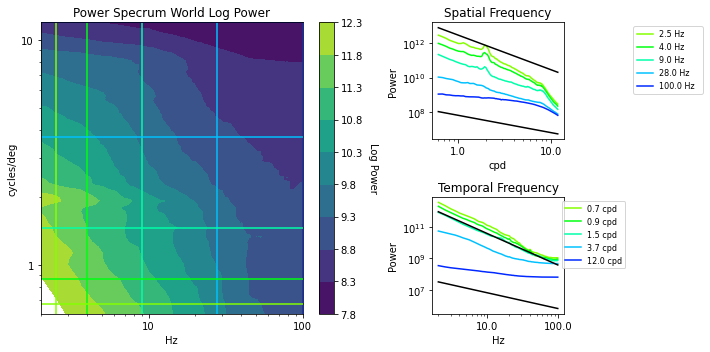

In [29]:
stf.da_plot_power(world_ps_all_grandmean, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  figname=f'Power Specrum World', 
                  saveloc='./output')

Sampling at: [  1   4  13  47 172], [  1   4  14  52 196] 


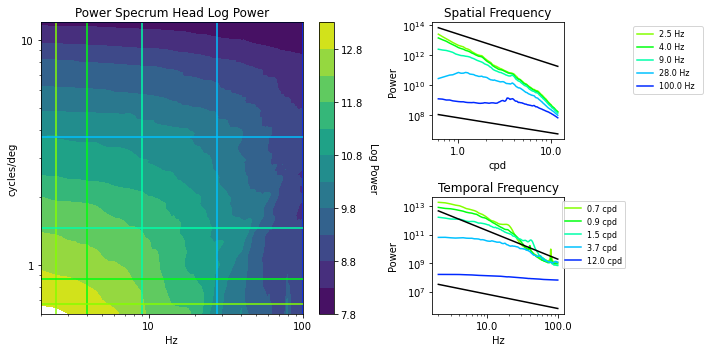

In [30]:
stf.da_plot_power(head_ps_all_grandmean, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  figname=f'Power Specrum Head', 
                  saveloc='./output')

Sampling at: [  1   4  13  47 172], [  1   4  14  52 196] 


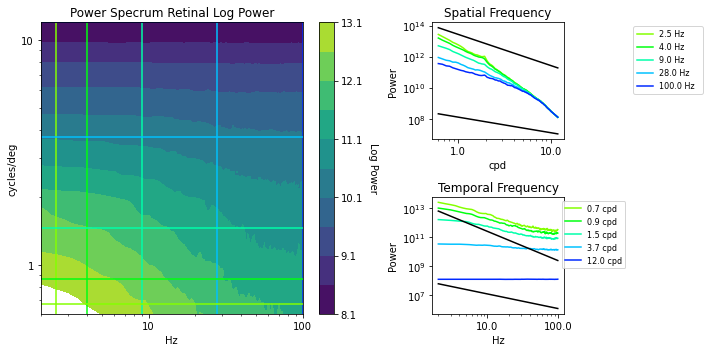

In [31]:
stf.da_plot_power(retinal_ps_all_grandmean, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  figname=f'Power Specrum Retinal', 
                  saveloc='./output')

In [32]:
#So we don't accidentally introduce a bug
static_ps_all_2d = world_ps_all_grandmean
headbody_ps_all_2d = head_ps_all_grandmean
eye_ps_all_2d = retinal_ps_all_grandmean

static_ps_horiz_2d = world_ps_horiz_grandmean
headbody_ps_horiz_2d = head_ps_horiz_grandmean
eye_ps_horiz_2d = retinal_ps_horiz_grandmean

static_ps_vert_2d = world_ps_vert_grandmean
headbody_ps_vert_2d = head_ps_vert_grandmean
eye_ps_vert_2d = retinal_ps_vert_grandmean

static_ps_ldiag_2d = world_ps_ldiag_grandmean
headbody_ps_ldiag_2d = head_ps_ldiag_grandmean
eye_ps_ldiag_2d = retinal_ps_ldiag_grandmean

static_ps_rdiag_2d = world_ps_rdiag_grandmean
headbody_ps_rdiag_2d = head_ps_rdiag_grandmean
eye_ps_rdiag_2d = retinal_ps_rdiag_grandmean

## Plot All on Same Color Axis

In [33]:
#spacecolors = plt.cm.get_cmap('hsv')


def da_plot_power(power_spectrum, fqspace, fqtime, nsamples = 5, minmaxcolors=(None, None), figname='Plot', saveloc='./output',
                  logscale=True, show_onef_line=True, vector_save=False, legend_loc=0, 
                  cmap_p='viridis', cmap_s='hsv', cmap_t='hsv'):
    '''
    THE Dong & Attick Plot (Dong & Attick 1995; fig 7) with heatmap added.
    Produces three plots:
        - Heatmap displying the joint spatial/temporal amplitude
        - Samples from this plot along spatial and temporal lines:
            * plots of spatial power spectrum along given temporal values
            * plots of temporal spectrum along given spatial values

    Parameters
    ----------
        power_spectrum:   2d numpy array of spatio/temporal power
        fqspace:    1d numpy array of spatial frequency vals for spectrum
        fqtime:   1d numpy array of temporal frequency vals for spectrum
        nsamples: integer number of lines to plot for sampling plots
        power (bool):   Are we calculating the power spectrum (default) or amplitude
        psd (bool):     Normalize to power spectral density (default), or raw power?
        figname (str):  String prefix to name of figure to be saved
    
    Returns:
    --------
        mftchunk
        azmchunk
        freqspace1d
        freqspacefull
        freqtime

    '''
    #dims got a little messed up. This is the quickest fix. Later go in and change idxs in code.
    #power_spectrum = power_spectrum.T
    
    #calculate sampling positions
    #space
    space_end_offset = 1
    space_end_sample = len(fqspace)-space_end_offset #sample everything for now
    #time
    time_end_offset = 1
    time_end_sample = len(fqtime)-time_end_offset #sample everything for now
    #joint
    n_datpoints = len(fqspace)*len(fqtime)
    
    #colors for lines: generate by indexes in log coordinates.
    spacesamplefqs_idx = np.round(np.geomspace(space_end_offset, space_end_sample,
                                      nsamples),0).astype(int)
    timesamplefqs_idx = np.round(np.geomspace(time_end_offset, time_end_sample,
                                     nsamples),0).astype(int)

    spacecolors = lambda x: plt.cm.get_cmap(cmap_s)(x / nsamples * 0.5 + 0.25)
#     spacecolors = np.array(['saddlebrown','brown', 'chocolate', 'darkgoldenrod','orange', 'gold','yellow'])#[::-1]
    timecolors = lambda x: plt.cm.get_cmap(cmap_t)(x / nsamples * 0.5 + 0.25)

    #make a grid
    fig = plt.figure(figsize=(9,5))
    full_grid = gsp.GridSpec(2,3)
    
    #layout of subplots
    grid_hm = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0:2,0:2])
    grid_time = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[1,2])
    grid_space = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0,2])
    
    #heatmap
    axes_hm = plt.subplot(grid_hm[0])
    
    #take log
    #power_spectrum = np.log10(power_spectrum)
    
    if(minmaxcolors[0]):
        minc = np.log10(np.abs(minmaxcolors[0]))
        maxc = np.log10(np.abs(minmaxcolors[1]))
    else:
        minc = np.min(np.log10(power_spectrum))
        maxc = np.max(np.log10(power_spectrum))

    clev = np.arange(minc,maxc,0.5)
    hm = axes_hm.contourf(fqtime, fqspace, np.log10(power_spectrum),
                              clev,
                              cmap=cmap_p,
                              norm=mpl.colors.Normalize(minc, maxc))    
    if(logscale):
        axes_hm.set_xscale("log") 
        axes_hm.set_yscale("log")
        
    axes_hm.set_xlabel('Hz')
    axes_hm.set_ylabel('cycles/deg')
    axes_hm.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axes_hm.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axes_hm.set_title(f'{figname} Log Power') 
    
    cb = plt.colorbar(hm, format='%.1f')
    #tick_locator = mpl.ticker.MaxNLocator(nbins=7)
    #cb.locator = tick_locator
    #cb.update_ticks()
    cb.ax.get_yaxis().labelpad = 15
    cb.ax.set_ylabel('Log Power', rotation=270)


    #add lines
    for s in range(nsamples):
        #lines in time
        axes_hm.axvline(fqtime[timesamplefqs_idx[s]],c=timecolors(s),ls='-')
        #lines in space
        axes_hm.axhline(fqspace[spacesamplefqs_idx[s]],c=spacecolors(s),ls='-')

    #spaceplot
    axes_space = plt.subplot(grid_space[0])
    for i, tf_idx in enumerate(timesamplefqs_idx):
        axes_space.loglog(fqspace, power_spectrum[:,tf_idx],
                        label='{0:.0f} Hz  '.format(fqtime[tf_idx]),
                        c=timecolors(i))
    
    #print(np.log(np.max(power_spectrum)/fqspace))
    if(show_onef_line):
        fqs = fqspace[space_end_offset:space_end_sample]
        onef = 1/(fqs) * np.min(power_spectrum[:,timesamplefqs_idx[-1]])
        onef2 = 1/(fqs)**2 * np.max(power_spectrum[:,timesamplefqs_idx[0]])
        axes_space.loglog(fqs, onef, c='black')
        axes_space.plot(fqs, onef2, c='black')
    
    axes_space.set_title('Spatial Frequency')
    axes_space.set_xlabel('cpd')
    axes_space.set_ylabel(f'Power')
    #axes_space.set_xlim(fqspace[1],fqspace[-1])
    #axes_space.set_ylim(bottom=minc, top=maxc)
    axes_space.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
    axes_space.legend(fontsize=8,loc=legend_loc, bbox_to_anchor=(1.5, 1.0))

    #timeplot
    axes_time = plt.subplot(grid_time[0])
    for i, sf_idx in enumerate(spacesamplefqs_idx):
        axes_time.loglog(fqtime, power_spectrum[sf_idx,:],
                       label='{0:0.1f} cpd'.format(fqspace[sf_idx]),
                       c=spacecolors(i))
        
    if(show_onef_line):
        fqs = fqtime[time_end_offset:time_end_sample]
        onef = 1/(fqs) * np.min(power_spectrum[:,timesamplefqs_idx[-1]])
        onef2 = 1/(fqs)**2 * np.max(power_spectrum[:,timesamplefqs_idx[0]])
        axes_time.loglog(fqs, onef, c='black')
        axes_time.plot(fqs, onef2, c='black')
        
    axes_time.set_title('Temporal Frequency')
    axes_time.set_xlabel('Hz')
    axes_time.set_ylabel(f'Power')
    #axes_time.set_xlim(fqtime[1],fqtime[-1])
    #axes_time.set_ylim(bottom=minc) #, top= maxc)
    axes_time.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
    axes_time.legend(fontsize=8,loc=legend_loc, bbox_to_anchor=(1.5, 1.0))

    plt.tight_layout()
    
    plt.savefig(f'{saveloc}/Power_{figname}.png')
    
    if(vector_save):
        plt.savefig(f'{saveloc}/Power_{figname}.eps',format='eps')
    

## Main Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


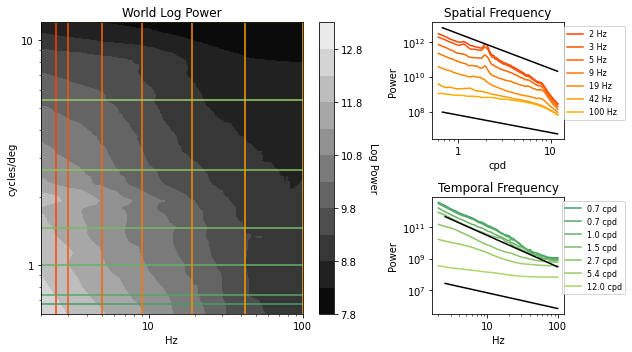

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


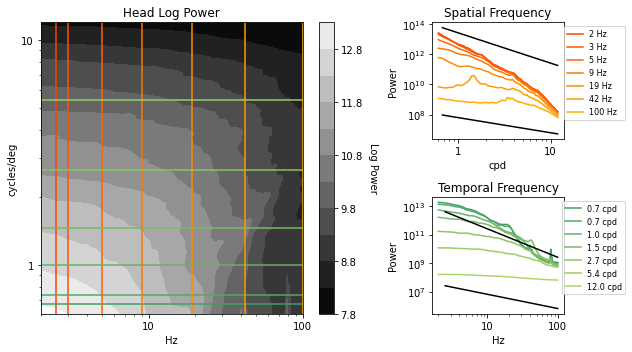

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


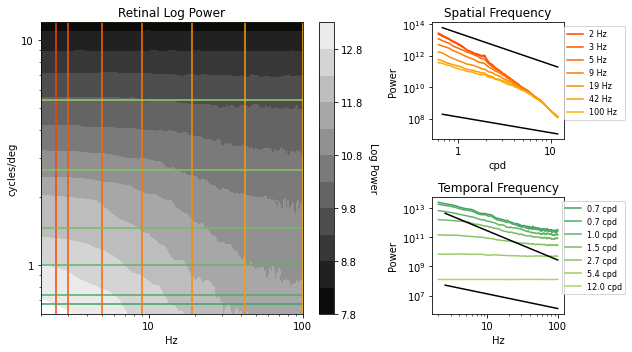

In [34]:
minc = np.min((static_ps_all_2d, headbody_ps_all_2d, eye_ps_all_2d))
maxc = np.max((static_ps_all_2d, headbody_ps_all_2d, eye_ps_all_2d))

da_plot_power(static_ps_all_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'World', 
                  saveloc=comparison_save_dir, vector_save=True, legend_loc=1, 
                  cmap_p='binary_r', cmap_s='summer', cmap_t='autumn')
plt.show()
da_plot_power(headbody_ps_all_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'Head', 
                  saveloc=comparison_save_dir, vector_save=True, legend_loc=1,
                  cmap_p='binary_r', cmap_s='summer', cmap_t='autumn')
plt.show()
da_plot_power(eye_ps_all_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'Retinal', 
                  saveloc=comparison_save_dir,vector_save=True, legend_loc=1,
                  cmap_p='binary_r', cmap_s='summer', cmap_t='autumn')

## Compare Directional

### Static

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


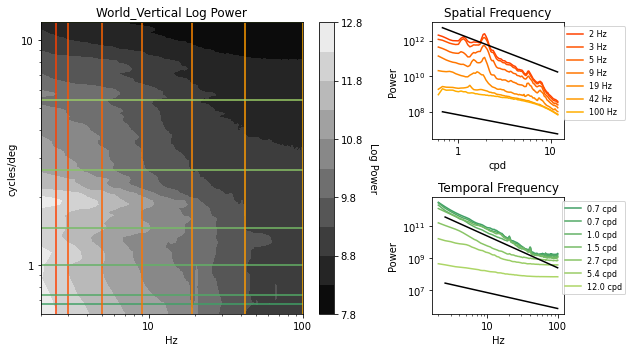

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


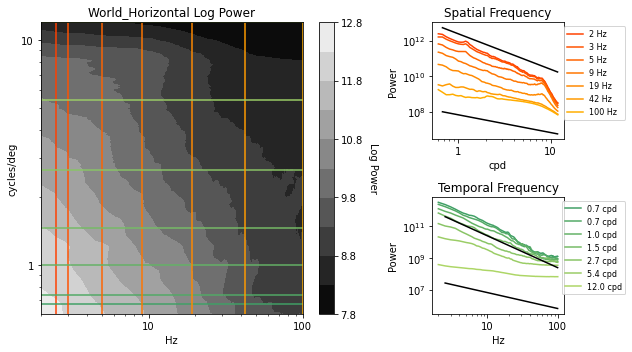

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


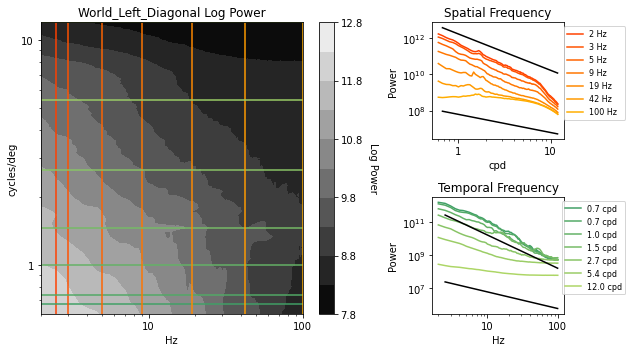

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


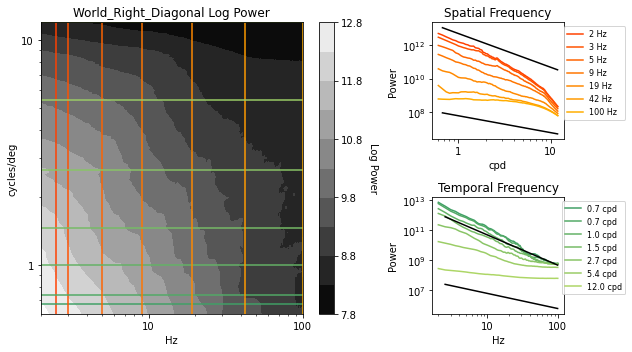

In [35]:
minc = np.min((static_ps_vert_2d, static_ps_horiz_2d, static_ps_ldiag_2d, static_ps_rdiag_2d))
maxc = np.max((static_ps_vert_2d, static_ps_horiz_2d, static_ps_ldiag_2d, static_ps_rdiag_2d))

da_plot_power(static_ps_vert_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'World_Vertical', 
                  saveloc=comparison_save_dir, vector_save=True, legend_loc=1, 
                  cmap_p='binary_r', cmap_s='summer', cmap_t='autumn')
plt.show()
da_plot_power(static_ps_horiz_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'World_Horizontal', 
                  saveloc=comparison_save_dir, vector_save=True, legend_loc=1,
                  cmap_p='binary_r', cmap_s='summer', cmap_t='autumn')
plt.show()
da_plot_power(static_ps_ldiag_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'World_Left_Diagonal', 
                  saveloc=comparison_save_dir,vector_save=True, legend_loc=1,
                  cmap_p='binary_r', cmap_s='summer', cmap_t='autumn')
plt.show()
da_plot_power(static_ps_rdiag_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'World_Right_Diagonal', 
                  saveloc=comparison_save_dir,vector_save=True, legend_loc=1,
                  cmap_p='binary_r', cmap_s='summer', cmap_t='autumn')

### Head

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


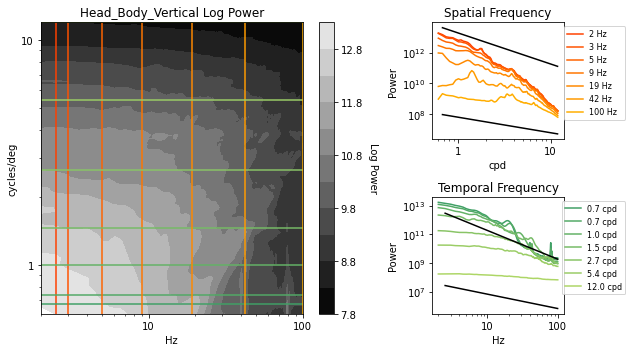

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


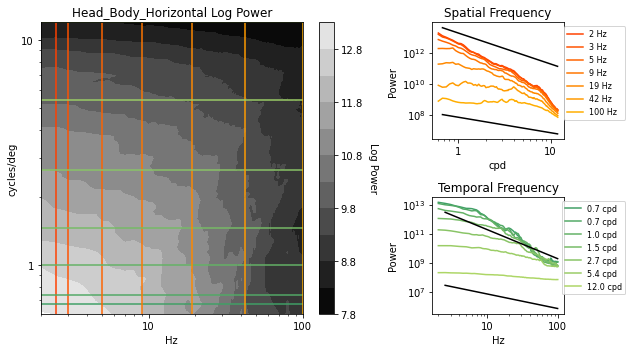

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


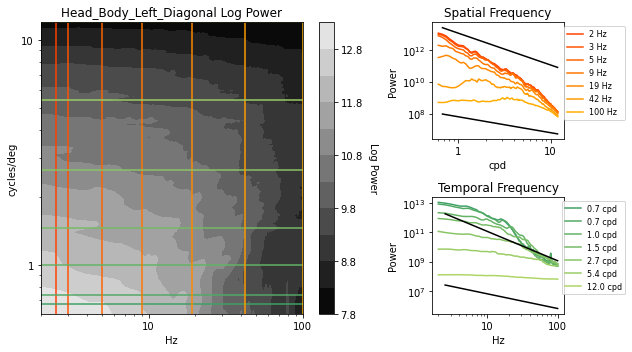

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


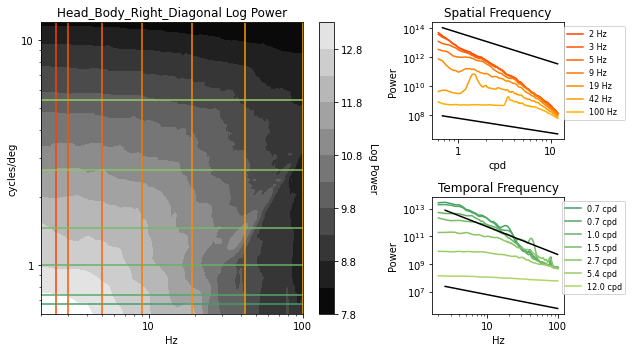

In [36]:
minc = np.min((headbody_ps_vert_2d, headbody_ps_horiz_2d, headbody_ps_ldiag_2d, headbody_ps_rdiag_2d))
maxc = np.max((headbody_ps_vert_2d, headbody_ps_horiz_2d, headbody_ps_ldiag_2d, headbody_ps_rdiag_2d))

da_plot_power(headbody_ps_vert_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'Head_Body_Vertical', 
                  saveloc=comparison_save_dir, vector_save=True, legend_loc=1, 
                  cmap_p='binary_r', cmap_s='summer', cmap_t='autumn')
plt.show()
da_plot_power(headbody_ps_horiz_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'Head_Body_Horizontal', 
                  saveloc=comparison_save_dir, vector_save=True, legend_loc=1,
                  cmap_p='binary_r', cmap_s='summer', cmap_t='autumn')
plt.show()
da_plot_power(headbody_ps_ldiag_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'Head_Body_Left_Diagonal', 
                  saveloc=comparison_save_dir,vector_save=True, legend_loc=1,
                  cmap_p='binary_r', cmap_s='summer', cmap_t='autumn')
plt.show()
da_plot_power(headbody_ps_rdiag_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'Head_Body_Right_Diagonal', 
                  saveloc=comparison_save_dir,vector_save=True, legend_loc=1,
                  cmap_p='binary_r', cmap_s='summer', cmap_t='autumn')

### Retinal

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


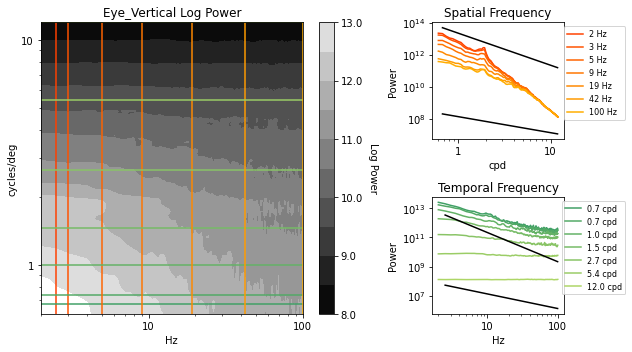

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


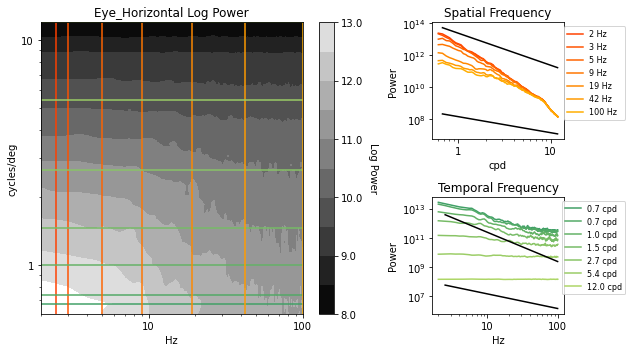

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


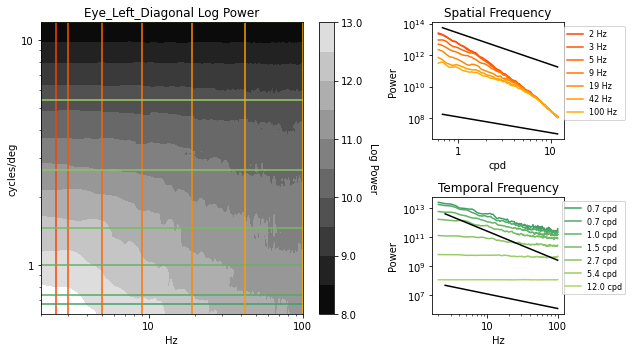

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


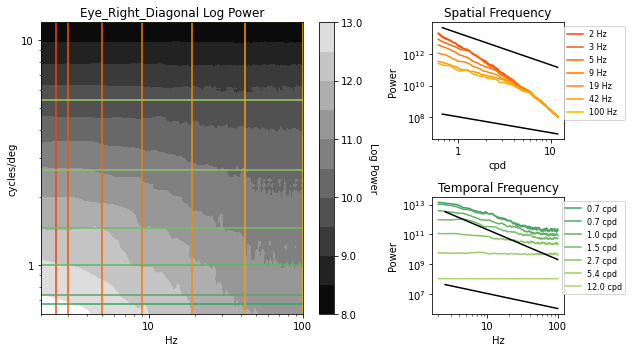

In [37]:
minc = np.min((eye_ps_vert_2d, eye_ps_horiz_2d, eye_ps_ldiag_2d, eye_ps_rdiag_2d))
maxc = np.max((eye_ps_vert_2d, eye_ps_horiz_2d, eye_ps_ldiag_2d, eye_ps_rdiag_2d))

da_plot_power(eye_ps_vert_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'Eye_Vertical', 
                  saveloc=comparison_save_dir, vector_save=True, legend_loc=1, 
                  cmap_p='binary_r', cmap_s='summer', cmap_t='autumn')
plt.show()
da_plot_power(eye_ps_horiz_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'Eye_Horizontal', 
                  saveloc=comparison_save_dir, vector_save=True, legend_loc=1,
                  cmap_p='binary_r', cmap_s='summer', cmap_t='autumn')
plt.show()
da_plot_power(eye_ps_ldiag_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'Eye_Left_Diagonal', 
                  saveloc=comparison_save_dir,vector_save=True, legend_loc=1,
                  cmap_p='binary_r', cmap_s='summer', cmap_t='autumn')
plt.show()
da_plot_power(eye_ps_rdiag_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  minmaxcolors=(minc, maxc), nsamples = 7,
                  figname=f'Eye_Right_Diagonal', 
                  saveloc=comparison_save_dir,vector_save=True, legend_loc=1,
                  cmap_p='binary_r', cmap_s='summer', cmap_t='autumn')

## Plotter of Diff Power
Need to put this inside the plotter because we'll take the difference in log space so we can see directionality.;

In [38]:
from matplotlib.ticker import FormatStrFormatter
def da_plot_diff_power(power_spectrum_a, power_spectrum_b, fqspace, fqtime, nsamples = 5, minmaxcolors=(None, None), figname='Plot', saveloc='./output', logscale=True, cmap= 'hsv', show_onef_line=True, grey_contour=True):
    '''
    THE Dong & Attick Plot (Dong & Attick 1995; fig 7) with heatmap added.
    Produces three plots:
        - Heatmap displying the joint spatial/temporal amplitude
        - Samples from this plot along spatial and temporal lines:
            * plots of spatial power spectrum along given temporal values
            * plots of temporal spectrum along given spatial values

    Parameters
    ----------
        power_spectrum:   2d numpy array of spatio/temporal power
        fqspace:    1d numpy array of spatial frequency vals for spectrum
        fqtime:   1d numpy array of temporal frequency vals for spectrum
        nsamples: integer number of lines to plot for sampling plots
        power (bool):   Are we calculating the power spectrum (default) or amplitude
        psd (bool):     Normalize to power spectral density (default), or raw power?
        figname (str):  String prefix to name of figure to be saved
    
    Returns:
    --------
        mftchunk
        azmchunk
        freqspace1d
        freqspacefull
        freqtime

    '''
    #dims got a little messed up. This is the quickest fix. Later go in and change idxs in code.
    #power_spectrum = power_spectrum.T
    
    #calculate sampling positions
    #space
    space_end_offset = 1
    space_end_sample = len(fqspace)-space_end_offset #sample everything for now
    #time
    time_end_offset = 1
    time_end_sample = len(fqtime)-time_end_offset #sample everything for now
    #joint
    n_datpoints = len(fqspace)*len(fqtime)
    
    #colors for lines: generate by indexes in log coordinates.
    spacesamplefqs_idx = np.round(np.geomspace(space_end_offset, space_end_sample,
                                      nsamples),0).astype(int)
    timesamplefqs_idx = np.round(np.geomspace(time_end_offset, time_end_sample,
                                     nsamples),0).astype(int)

    #spacecolors = np.array(['red', 'orange', 'green', 'blue', 'indigo'])#[::-1]
    spacecolors = lambda x: plt.cm.get_cmap(cmap)(x / nsamples * 0.5 + 0.25)
    timecolors = spacecolors

    #make a grid
    fig = plt.figure(figsize=(10,6))
    full_grid = gsp.GridSpec(2,3)
    
    #layout of subplots
    grid_hm = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0:2,0:2])
    grid_time = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[1,2])
    grid_space = gsp.GridSpecFromSubplotSpec(1,1,subplot_spec=full_grid[0,2])
    
    #heatmap
    axes_hm = plt.subplot(grid_hm[0])
    
    #take log
    power_spectrum_d = np.log10(power_spectrum_a) - np.log10(power_spectrum_b)
    
    if(minmaxcolors[0] and minmaxcolors[1]):
        minc = minmaxcolors[0]
        maxc = minmaxcolors[1]
    else:
        minc = np.min(power_spectrum_d)
        maxc = np.max(power_spectrum_d)
        
    clev = np.arange(minc,maxc,0.5)
    hm = axes_hm.contourf(fqtime, fqspace, power_spectrum_d,
                              clev,
                              cmap='PiYG_r',
                              norm=mpl.colors.DivergingNorm(vmin=minc, vcenter=0, vmax=maxc))
    if(logscale):
        axes_hm.set_xscale("log") 
        axes_hm.set_yscale("log")
    axes_hm.set_xlabel('Temporal Frequency (cycles/sec)')
    axes_hm.set_ylabel('Spatial Frequency (cycles/deg)')
    axes_hm.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axes_hm.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    axes_hm.set_title(f'{figname} Log Power') 
    
    cb = plt.colorbar(hm, format='%.1f')
    #tick_locator = mpl.ticker.MaxNLocator(nbins=5)
    #cb.locator = tick_locator
    #cb.update_ticks()
    cb.ax.get_yaxis().labelpad = 15
    cb.ax.set_ylabel('Differnece in Log Power', rotation=270)

#     #add lines
#     for s in range(nsamples):
#         #lines in time
#         axes_hm.axvline(fqtime[timesamplefqs_idx[s]],c=timecolors(s),ls='-')
#         #lines in space
#         axes_hm.axhline(fqspace[spacesamplefqs_idx[s]],c=spacecolors(s),ls='--')

    #spaceplot
    axes_space = plt.subplot(grid_space[0])
    for i, tf_idx in enumerate(timesamplefqs_idx):
        axes_space.semilogx(fqspace, power_spectrum_d[:,tf_idx],
                        label='{0:0.1f} Hz'.format(fqtime[tf_idx]),
                        c=timecolors(i))
    
    #print(np.log(np.max(power_spectrum)/fqspace))
    if(show_onef_line):
        fqs = fqspace[space_end_offset:space_end_sample]
        onef = 1/(fqs) * np.min(power_spectrum_d[:,timesamplefqs_idx[-1]])
        onef2 = 1/(fqs)**2 * np.max(power_spectrum_d[:,timesamplefqs_idx[0]])
        axes_space.loglog(fqs, onef, c='black')
        axes_space.plot(fqs, onef2, c='black')
    
    axes_space.set_title('Spatial Frequency')
    axes_space.set_xlabel('cpd')
    axes_space.set_ylabel(f'Power')
    #axes_space.set_xlim(fqspace[1],fqspace[-1])
    #axes_space.set_ylim(bottom=minc) #, top=maxc)
    axes_space.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
    axes_space.legend(fontsize=8)

    #timeplot
    axes_time = plt.subplot(grid_time[0])
    for i, sf_idx in enumerate(spacesamplefqs_idx):
        axes_time.semilogx(fqtime, power_spectrum_d[sf_idx,:],
                       label='{0:0.1f} cpd'.format(fqspace[sf_idx]),
                       c=spacecolors(i))
        
    if(show_onef_line):
        fqs = fqtime[time_end_offset:time_end_sample]
        onef = 1/(fqs) * np.min(power_spectrum_d[:,timesamplefqs_idx[-1]])
        onef2 = 1/(fqs)**2 * np.max(power_spectrum_d[:,timesamplefqs_idx[0]])
        axes_time.semilogx(fqs, onef, c='black')
        axes_time.plot(fqs, onef2, c='black')
        
    axes_time.set_title('Temporal Frequency')
    axes_time.set_xlabel('Hz')
    axes_time.set_ylabel(f'Power')
    #axes_time.set_xlim(fqtime[1],fqtime[-1])
    #axes_time.set_ylim(bottom=minc) #, top= maxc)
    axes_time.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
    axes_time.legend(fontsize=8)

    plt.tight_layout()
    
    plt.savefig(f'{saveloc}/Power_{figname}.png')

## Differences: All Directions

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


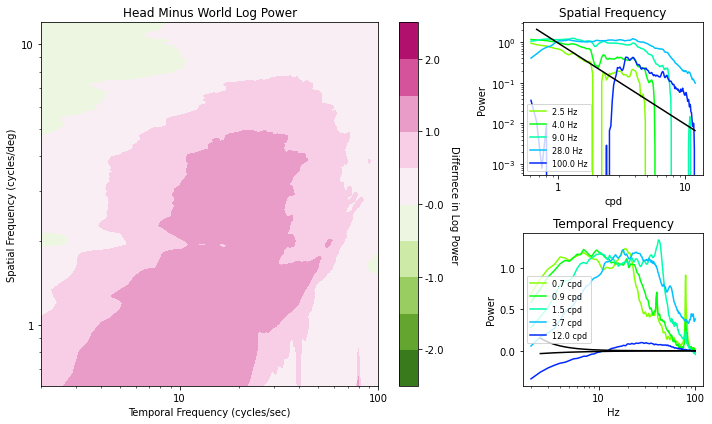

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


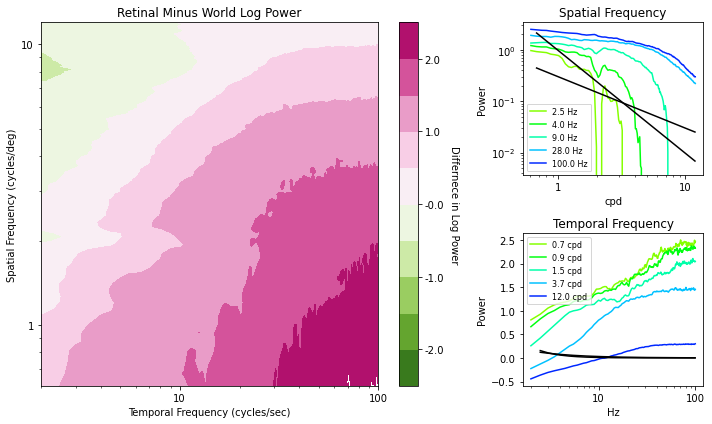

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


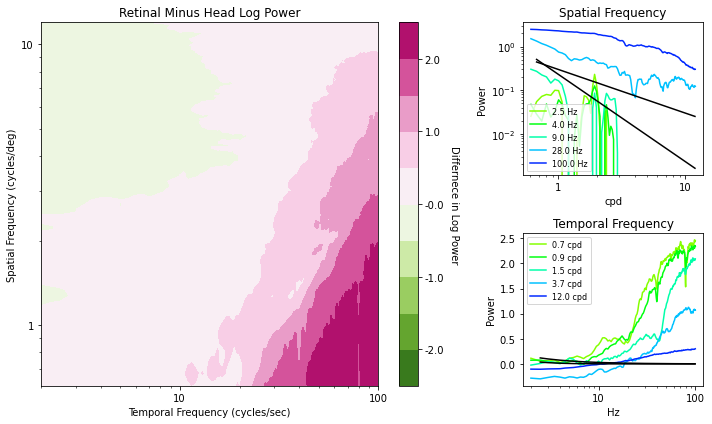

In [39]:
minc = np.min((np.log10(headbody_ps_all_2d)-np.log10(static_ps_all_2d),
              np.log10(eye_ps_all_2d)-np.log10(static_ps_all_2d),
              np.log10(eye_ps_all_2d)-np.log10(headbody_ps_all_2d)))
maxc = np.max((np.log10(headbody_ps_all_2d)-np.log10(static_ps_all_2d),
              np.log10(eye_ps_all_2d)-np.log10(static_ps_all_2d),
              np.log10(eye_ps_all_2d)-np.log10(headbody_ps_all_2d)))
mincabs = np.max((np.abs(minc), np.abs(maxc)))
minc = -1*mincabs
maxc = mincabs

#headbody vs static
da_plot_diff_power(headbody_ps_all_2d, static_ps_all_2d, fqs_space, fqs_time, 
                   show_onef_line=True, logscale=True,
                  figname=f'Head Minus World', 
                  saveloc=comparison_save_dir, grey_contour=False,
                  minmaxcolors=(minc, maxc))
plt.show()
#static vs eye
da_plot_diff_power(eye_ps_all_2d, static_ps_all_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  figname=f'Retinal Minus World', 
                  saveloc=comparison_save_dir, grey_contour=False,
                    minmaxcolors=(minc, maxc))
plt.show()

#body vs eye
da_plot_diff_power(eye_ps_all_2d, headbody_ps_all_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  figname=f'Retinal Minus Head', 
                  saveloc=comparison_save_dir, grey_contour=False,
                    minmaxcolors=(minc, maxc))

## Differences: Vertical

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


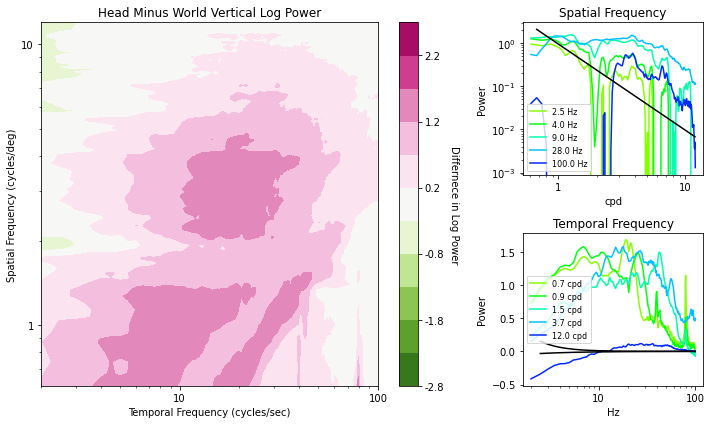

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


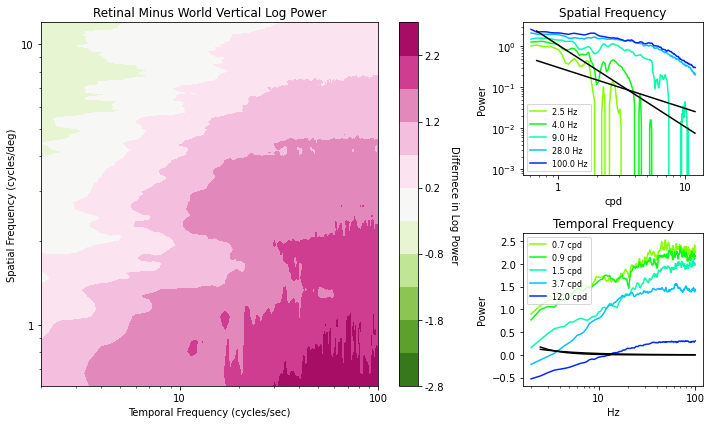

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


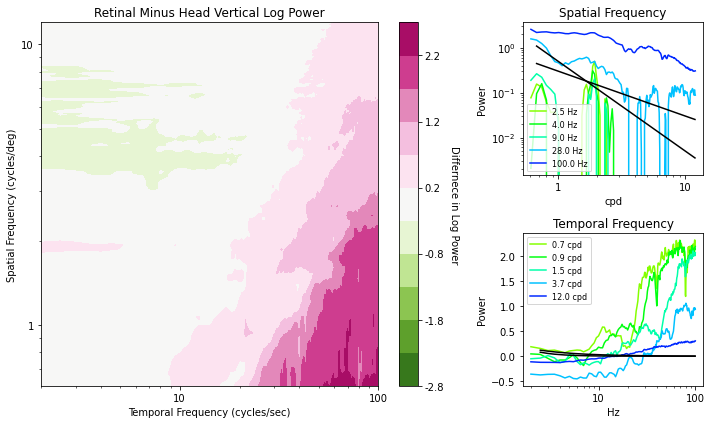

In [40]:
minc = np.min((np.log10(headbody_ps_vert_2d)-np.log10(static_ps_vert_2d),
              np.log10(eye_ps_vert_2d)-np.log10(static_ps_vert_2d),
              np.log10(eye_ps_vert_2d)-np.log10(headbody_ps_vert_2d)))
maxc = np.max((np.log10(headbody_ps_vert_2d)-np.log10(static_ps_vert_2d),
              np.log10(eye_ps_vert_2d)-np.log10(static_ps_vert_2d),
              np.log10(eye_ps_vert_2d)-np.log10(headbody_ps_vert_2d)))
mincabs = np.max((np.abs(minc), np.abs(maxc)))
minc = -1*mincabs
maxc = mincabs

#headbody vs static
da_plot_diff_power(headbody_ps_vert_2d, static_ps_vert_2d, fqs_space, fqs_time, 
                   show_onef_line=True, logscale=True,
                  figname=f'Head Minus World Vertical', 
                  saveloc=comparison_save_dir, grey_contour=False,
                  minmaxcolors=(minc, maxc))
plt.show()
#static vs eye
da_plot_diff_power(eye_ps_vert_2d, static_ps_vert_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  figname=f'Retinal Minus World Vertical', 
                  saveloc=comparison_save_dir, grey_contour=False,
                    minmaxcolors=(minc, maxc))
plt.show()

#body vs eye
da_plot_diff_power(eye_ps_vert_2d, headbody_ps_vert_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  figname=f'Retinal Minus Head Vertical', 
                  saveloc=comparison_save_dir, grey_contour=False,
                    minmaxcolors=(minc, maxc))

## Differences: Horizontal

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


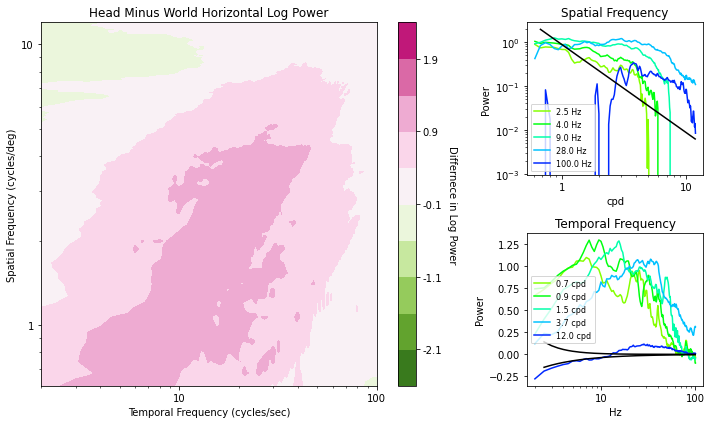

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


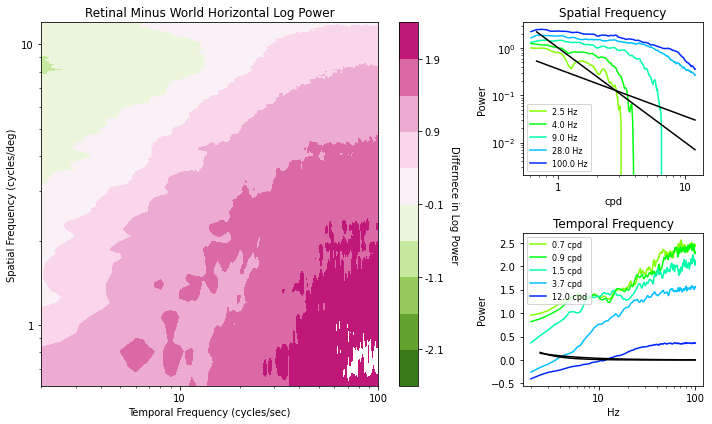

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


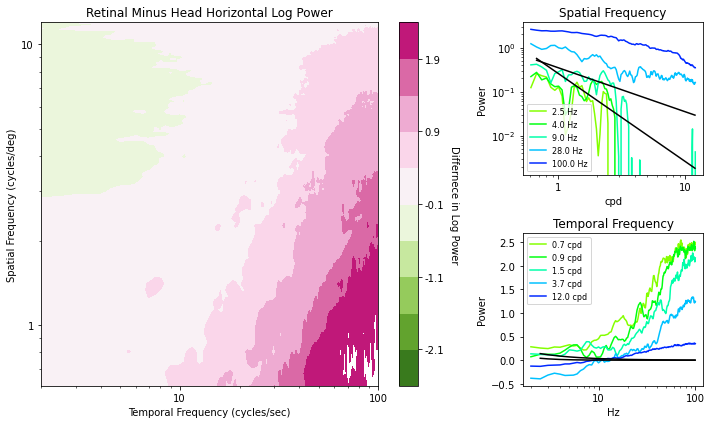

In [41]:
minc = np.min((np.log10(headbody_ps_horiz_2d)-np.log10(static_ps_horiz_2d),
              np.log10(eye_ps_horiz_2d)-np.log10(static_ps_horiz_2d),
              np.log10(eye_ps_horiz_2d)-np.log10(headbody_ps_horiz_2d)))
maxc = np.max((np.log10(headbody_ps_horiz_2d)-np.log10(static_ps_horiz_2d),
              np.log10(eye_ps_horiz_2d)-np.log10(static_ps_horiz_2d),
              np.log10(eye_ps_horiz_2d)-np.log10(headbody_ps_horiz_2d)))
mincabs = np.max((np.abs(minc), np.abs(maxc)))
minc = -1*mincabs
maxc = mincabs

#headbody vs static
da_plot_diff_power(headbody_ps_horiz_2d, static_ps_horiz_2d, fqs_space, fqs_time, 
                   show_onef_line=True, logscale=True,
                  figname=f'Head Minus World Horizontal', 
                  saveloc=comparison_save_dir, grey_contour=False,
                  minmaxcolors=(minc, maxc))
plt.show()
#static vs eye
da_plot_diff_power(eye_ps_horiz_2d, static_ps_horiz_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  figname=f'Retinal Minus World Horizontal', 
                  saveloc=comparison_save_dir, grey_contour=False,
                    minmaxcolors=(minc, maxc))
plt.show()

#body vs eye
da_plot_diff_power(eye_ps_horiz_2d, headbody_ps_horiz_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  figname=f'Retinal Minus Head Horizontal', 
                  saveloc=comparison_save_dir, grey_contour=False,
                    minmaxcolors=(minc, maxc))

## Differences: Left Diagonal

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


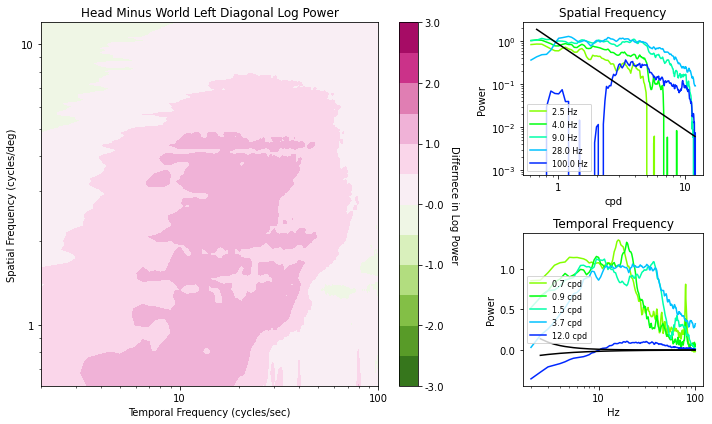

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


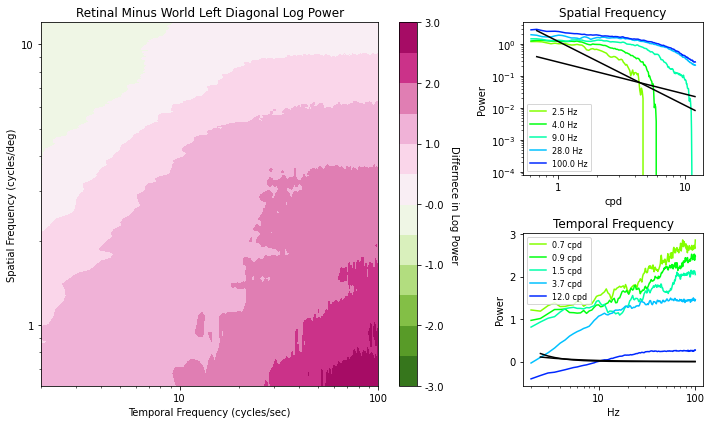

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


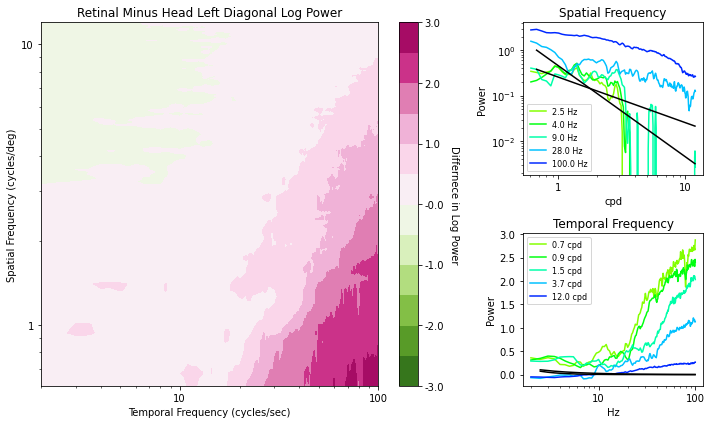

In [42]:
minc = np.min((np.log10(headbody_ps_ldiag_2d)-np.log10(static_ps_ldiag_2d),
              np.log10(eye_ps_ldiag_2d)-np.log10(static_ps_ldiag_2d),
              np.log10(eye_ps_ldiag_2d)-np.log10(headbody_ps_ldiag_2d)))
maxc = np.max((np.log10(headbody_ps_ldiag_2d)-np.log10(static_ps_ldiag_2d),
              np.log10(eye_ps_ldiag_2d)-np.log10(static_ps_ldiag_2d),
              np.log10(eye_ps_ldiag_2d)-np.log10(headbody_ps_ldiag_2d)))
mincabs = np.max((np.abs(minc), np.abs(maxc)))
minc = -1*mincabs
maxc = mincabs

#headbody vs static
da_plot_diff_power(headbody_ps_ldiag_2d, static_ps_ldiag_2d, fqs_space, fqs_time, 
                   show_onef_line=True, logscale=True,
                  figname=f'Head Minus World Left Diagonal', 
                  saveloc=comparison_save_dir, grey_contour=False,
                  minmaxcolors=(minc, maxc))
plt.show()
#static vs eye
da_plot_diff_power(eye_ps_ldiag_2d, static_ps_ldiag_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  figname=f'Retinal Minus World Left Diagonal', 
                  saveloc=comparison_save_dir, grey_contour=False,
                    minmaxcolors=(minc, maxc))
plt.show()

#body vs eye
da_plot_diff_power(eye_ps_ldiag_2d, headbody_ps_ldiag_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  figname=f'Retinal Minus Head Left Diagonal', 
                  saveloc=comparison_save_dir, grey_contour=False,
                    minmaxcolors=(minc, maxc))

## Differences: Right Diagonal

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


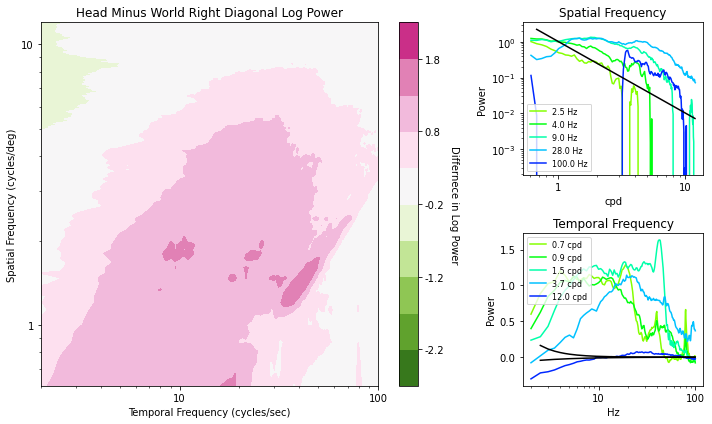

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


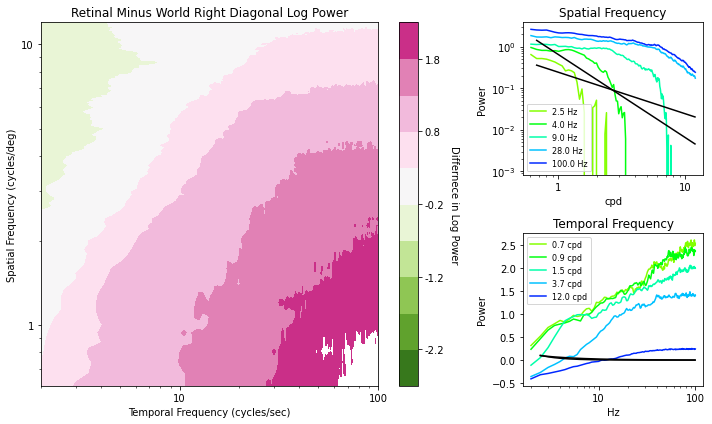

/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


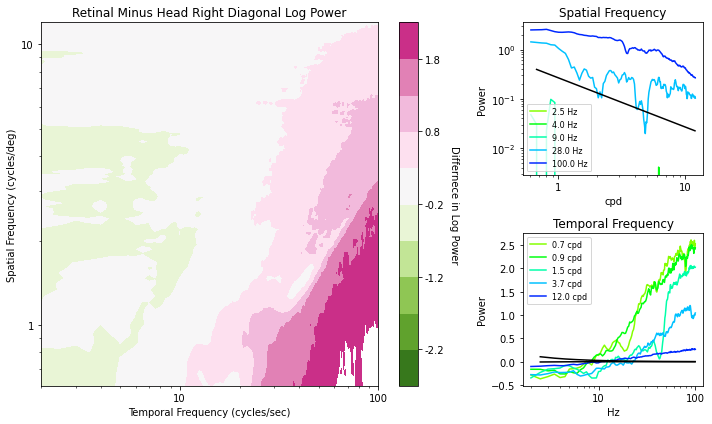

In [43]:
minc = np.min((np.log10(headbody_ps_rdiag_2d)-np.log10(static_ps_rdiag_2d),
              np.log10(eye_ps_rdiag_2d)-np.log10(static_ps_rdiag_2d),
              np.log10(eye_ps_rdiag_2d)-np.log10(headbody_ps_rdiag_2d)))
maxc = np.max((np.log10(headbody_ps_rdiag_2d)-np.log10(static_ps_rdiag_2d),
              np.log10(eye_ps_rdiag_2d)-np.log10(static_ps_rdiag_2d),
              np.log10(eye_ps_rdiag_2d)-np.log10(headbody_ps_rdiag_2d)))
mincabs = np.max((np.abs(minc), np.abs(maxc)))
minc = -1*mincabs
maxc = mincabs

#headbody vs static
da_plot_diff_power(headbody_ps_rdiag_2d, static_ps_rdiag_2d, fqs_space, fqs_time, 
                   show_onef_line=True, logscale=True,
                  figname=f'Head Minus World Right Diagonal', 
                  saveloc=comparison_save_dir, grey_contour=False,
                  minmaxcolors=(minc, maxc))
plt.show()
#static vs eye
da_plot_diff_power(eye_ps_rdiag_2d, static_ps_rdiag_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  figname=f'Retinal Minus World Right Diagonal', 
                  saveloc=comparison_save_dir, grey_contour=False,
                    minmaxcolors=(minc, maxc))
plt.show()

#body vs eye
da_plot_diff_power(eye_ps_rdiag_2d, headbody_ps_rdiag_2d, fqs_space, fqs_time, show_onef_line=True, logscale=True,
                  figname=f'Retinal Minus Head Right Diagonal', 
                  saveloc=comparison_save_dir, grey_contour=False,
                    minmaxcolors=(minc, maxc))

## Velocities

What velocities are present in these natural signals? How is this modulated by motion types introduced?


In [44]:
print(f'Spatial Freqs range from : {min(fqs_space):.2f} to {max(fqs_space):.2f}')
print(f'Temporal Freqs range from : {min(fqs_time)} to {max(fqs_time)}')
print(f'Max Velocity Represented is {max(fqs_time)/min(fqs_space):.2f} deg/sec')
print(f'Max Velocity Represented is {min(fqs_time)/max(fqs_space):.2f} deg/sec')

Spatial Freqs range from : 0.61 to 11.97
Temporal Freqs range from : 2.0 to 100.0
Max Velocity Represented is 164.42 deg/sec
Max Velocity Represented is 0.17 deg/sec


/home/vasha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


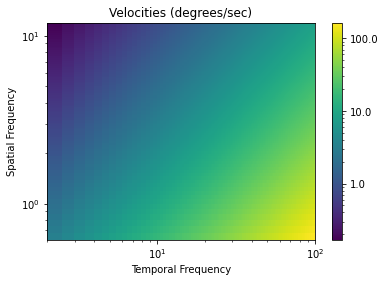

In [45]:
xx, yy = np.meshgrid(fqs_time, fqs_space)
velocity = xx/yy
plt.pcolormesh(fqs_time, fqs_space, velocity,
               norm=colors.LogNorm(vmin=velocity.min(), vmax=velocity.max()))
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Temporal Frequency')
plt.ylabel('Spatial Frequency')
plt.title('Velocities (degrees/sec)')
plt.colorbar(format='%.1f')

In [46]:
imp.reload(stf)
bil=False
bins = 20
retinal_all_bins, retinal_all_v_spectrum = stf.calc_velocity_spec(eye_ps_all_2d, fqs_space, fqs_time, nbins=bins, bin_in_log = bil)
retinal_vert_bins, retinal_vert_v_spectrum = stf.calc_velocity_spec(eye_ps_vert_2d, fqs_space, fqs_time, nbins=bins, bin_in_log = bil)
retinal_horiz_bins, retinal_horiz_v_spectrum = stf.calc_velocity_spec(eye_ps_horiz_2d, fqs_space, fqs_time, nbins=bins, bin_in_log = bil)
retinal_ldiag_bins, retinal_ldiag_v_spectrum = stf.calc_velocity_spec(eye_ps_ldiag_2d, fqs_space, fqs_time, nbins=bins, bin_in_log = bil)
retinal_rdiag_bins, retinal_rdiag_v_spectrum = stf.calc_velocity_spec(eye_ps_rdiag_2d, fqs_space, fqs_time, nbins=bins, bin_in_log = bil)

ego_all_bins, ego_all_v_spectrum = stf.calc_velocity_spec(headbody_ps_all_2d, fqs_space, fqs_time, nbins=bins, bin_in_log = bil)
ego_vert_bins, ego_vert_v_spectrum = stf.calc_velocity_spec(headbody_ps_vert_2d, fqs_space, fqs_time, nbins=bins, bin_in_log = bil)
ego_horiz_bins, ego_horiz_v_spectrum = stf.calc_velocity_spec(headbody_ps_horiz_2d, fqs_space, fqs_time, nbins=bins, bin_in_log = bil)
ego_ldiag_bins, ego_ldiag_v_spectrum = stf.calc_velocity_spec(headbody_ps_ldiag_2d, fqs_space, fqs_time, nbins=bins, bin_in_log = bil)
ego_rdiag_bins, ego_rdiag_v_spectrum = stf.calc_velocity_spec(headbody_ps_rdiag_2d, fqs_space, fqs_time, nbins=bins, bin_in_log = bil)

environment_all_bins, environment_all_v_spectrum = stf.calc_velocity_spec(static_ps_all_2d, fqs_space, fqs_time, nbins=bins, bin_in_log = bil)
environment_vert_bins, environment_vert_v_spectrum = stf.calc_velocity_spec(static_ps_vert_2d, fqs_space, fqs_time, nbins=bins, bin_in_log = bil)
environment_horiz_bins, environment_horiz_v_spectrum = stf.calc_velocity_spec(static_ps_horiz_2d, fqs_space, fqs_time, nbins=bins, bin_in_log = bil)
environment_ldiag_bins, environment_ldiag_v_spectrum = stf.calc_velocity_spec(static_ps_ldiag_2d, fqs_space, fqs_time, nbins=bins, bin_in_log = bil)
environment_rdiag_bins, environment_rdiag_v_spectrum = stf.calc_velocity_spec(static_ps_rdiag_2d, fqs_space, fqs_time, nbins=bins, bin_in_log = bil)

/home/vasha/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vasha/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


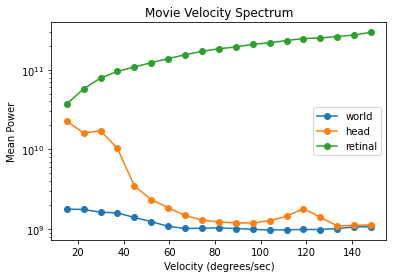

In [47]:
logv = False
stf.plot_velocity_spec(environment_all_bins[2:], environment_all_v_spectrum[2:], f'world', log_v=logv)
stf.plot_velocity_spec(ego_all_bins[2:], ego_all_v_spectrum[2:], f'head', log_v=logv)
stf.plot_velocity_spec(retinal_all_bins[2:], retinal_all_v_spectrum[2:], f'retinal', log_v=logv)
plt.savefig(os.path.join(comparison_save_dir, f'Velocity_Spectrum_All_Comparison'))

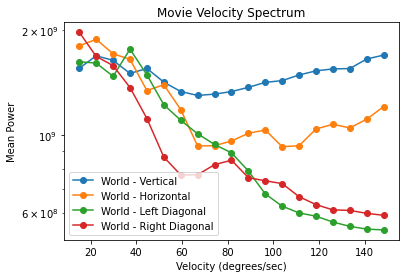

In [48]:
logv = False
#stf.plot_velocity_spec(environment_all_bins[2:], environment_all_v_spectrum[2:], f'World - All', log_v=logv)
stf.plot_velocity_spec(environment_vert_bins[2:], environment_vert_v_spectrum[2:], f'World - Vertical', log_v=logv)
stf.plot_velocity_spec(environment_horiz_bins[2:], environment_horiz_v_spectrum[2:], f'World - Horizontal', log_v=logv)
stf.plot_velocity_spec(environment_ldiag_bins[2:], environment_ldiag_v_spectrum[2:], f'World - Left Diagonal', log_v=logv)
stf.plot_velocity_spec(environment_rdiag_bins[2:], environment_rdiag_v_spectrum[2:], f'World - Right Diagonal', log_v=logv)

plt.savefig(os.path.join(comparison_save_dir, f'Velocity_Spectrum_Directional_World'))

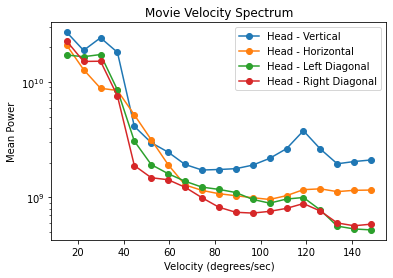

In [49]:
logv = False
#stf.plot_velocity_spec(ego_all_bins[2:], ego_all_v_spectrum[2:], f'Head - All', log_v=logv)
stf.plot_velocity_spec(ego_vert_bins[2:], ego_vert_v_spectrum[2:], f'Head - Vertical', log_v=logv)
stf.plot_velocity_spec(ego_horiz_bins[2:], ego_horiz_v_spectrum[2:], f'Head - Horizontal', log_v=logv)
stf.plot_velocity_spec(ego_ldiag_bins[2:], ego_ldiag_v_spectrum[2:], f'Head - Left Diagonal', log_v=logv)
stf.plot_velocity_spec(ego_rdiag_bins[2:], ego_rdiag_v_spectrum[2:], f'Head - Right Diagonal', log_v=logv)

plt.savefig(os.path.join(comparison_save_dir, f'Velocity_Spectrum_Directional_Head'))

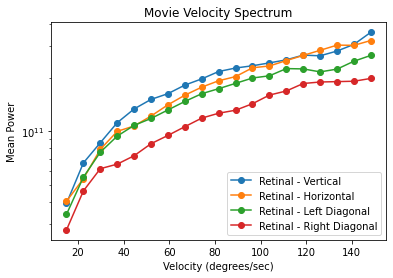

In [50]:
logv = False
#stf.plot_velocity_spec(retinal_all_bins[2:], retinal_all_v_spectrum[2:], f'Retinal - All', log_v=logv)
stf.plot_velocity_spec(retinal_vert_bins[2:], retinal_vert_v_spectrum[2:], f'Retinal - Vertical', log_v=logv)
stf.plot_velocity_spec(retinal_horiz_bins[2:], retinal_horiz_v_spectrum[2:], f'Retinal - Horizontal', log_v=logv)
stf.plot_velocity_spec(retinal_ldiag_bins[2:], retinal_ldiag_v_spectrum[2:], f'Retinal - Left Diagonal', log_v=logv)
stf.plot_velocity_spec(retinal_rdiag_bins[2:], retinal_rdiag_v_spectrum[2:], f'Retinal - Right Diagonal', log_v=logv)

plt.savefig(os.path.join(comparison_save_dir, f'Velocity_Spectrum_Directional_Retinal'))